In [1]:
from hcmus.utils import data_utils, transform_utils

splits = data_utils.get_data_splits()

2025-07-11 08:20:42.175 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-07-11 08:20:44.106 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 3443 tasks available.
2025-07-11 08:20:44.107 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 35
Loading tasks: 100%|██████████| 35/35 [00:11<00:00,  3.03it/s]
2025-07-11 08:21:02.314 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 418 tasks available.
2025-07-11 08:21:02.314 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 5
Loading tasks: 100%|██████████| 5/5 [00:03<00:00,  1

In [2]:
import random
from torchvision import transforms as T

def get_transforms():
    transform_train = T.Compose([
        T.Lambda(lambda img: T.Resize(random.randint(32, 224))(img)),
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(180),
        T.ColorJitter(
            brightness=0.2,
            contrast=0.0,
            saturation=0.0,
            hue=0.0
        ),
        T.RandomResizedCrop(
            size=224,
            scale=(0.8, 1.2),
            ratio=(0.75, 1.3333)
        ),
        T.RandAugment(num_ops=5),
        T.ToTensor()
    ])

    transform_test = T.Compose([
        # T.Resize((size, size)),
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    return transform_train, transform_test

In [3]:
transform_train, transform_test = get_transforms()
datasets = data_utils.get_image_datasets_v2(splits, transform_train, transform_test, random_margin=0.2)
dataloaders = data_utils.get_data_loaders_v2(datasets, {
    "train": True
})

2025-07-11 08:21:11.004 | INFO     | hcmus.data._torch_dataset_v2:__init__:56 - Apply random_margin=0.2
2025-07-11 08:21:11.291 | INFO     | hcmus.data._torch_dataset_v2:__init__:67 - Auto infer `label2idx` mapping, mapping length: 99.
2025-07-11 08:21:11.295 | INFO     | hcmus.data._torch_dataset_v2:__init__:56 - Apply random_margin=0
2025-07-11 08:21:11.645 | INFO     | hcmus.data._torch_dataset_v2:__init__:56 - Apply random_margin=0


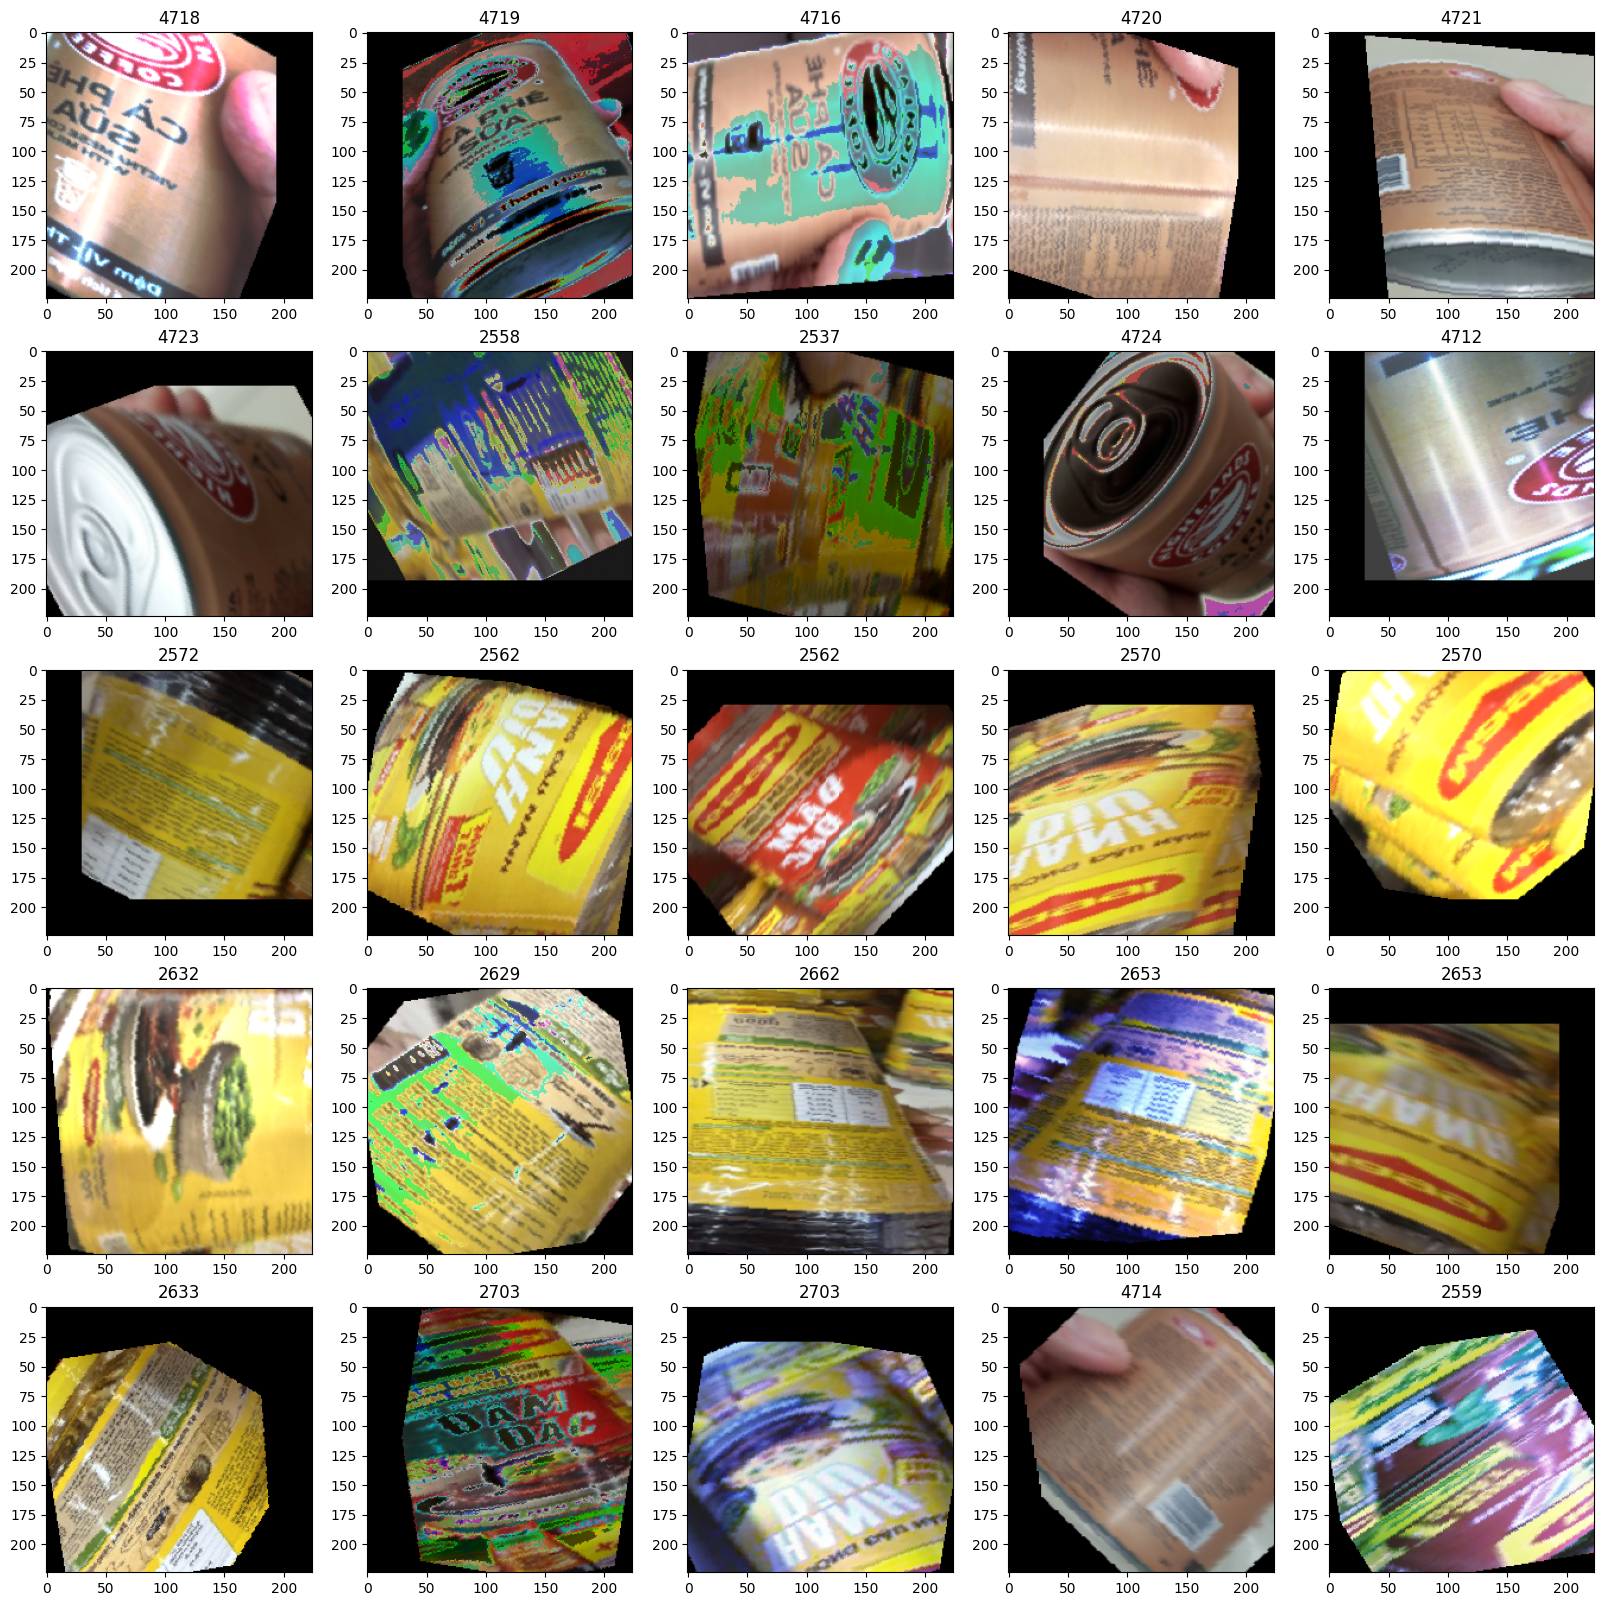

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
idx = 0
for x in range(5):
    for y in range(5):
        plt.subplot(5, 5, idx + 1)
        image, _, task = datasets["train"][idx]
        image = image.detach().numpy().transpose(1, 2, 0)
        plt.imshow(image)
        plt.title(task.get("task_id"))
        idx += 1

In [5]:
from hcmus.models.backbone import CLIPBackbone
from hcmus.models.backbone import DinoBackbone
from hcmus.models.transfer import TransferNetwork
from hcmus.models.transfer import TransferTrainer

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
backbone_list = [
    # (DinoBackbone, {"model_id": "facebook/dinov2-small"}),
    # (DinoBackbone, {"model_id": "facebook/dinov2-base"}),
    # (DinoBackbone, {"model_id": "facebook/dino-vitb8"}),
    # (DinoBackbone, {"model_id": "facebook/dino-vits8"}),
    (DinoBackbone, {"model_id": "facebook/dino-vits16"}),
    # (DinoBackbone, {"model_id": "facebook/dino-vitb16"}),
    (CLIPBackbone, {"backbone_name": "ViT-B/32"}),
    (CLIPBackbone, {"backbone_name": "ViT-B/16"}),
]

In [7]:
import mlflow
def get_or_create_experiment():
    name = "/TransferLearning"
    try:
        mlflow.create_experiment(name)
    except:
        pass

    return mlflow.get_experiment_by_name(name).experiment_id

In [8]:
from hcmus.utils import mlflow_utils
get_or_create_experiment()
for cls, params in backbone_list:
    mlflow.end_run()
    backbone = cls(**params)
    model = TransferNetwork(backbone, output_dim=99)
    trainer = TransferTrainer(
        model=model,
        mlflow_experiment_name="/TransferLearning",
        mlflow_run_name=cls.__name__ + f"/{params}"
    )
    trainer.train(32, dataloaders["train"], dataloaders["val"])
    trainer.load_model("best_model.pt")
    trainer.evaluate(dataloaders["test"], log_mlflow=True)
    mlflow_utils.log_json_artifact(datasets["train"].label2idx, "label2idx.json")
    trainer.end_run()

Epoch 1/32: 100%|██████████| 84/84 [01:20<00:00,  1.04it/s, Loss=3.6324]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:24:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:24:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/32:
  Train Loss: 3.9751
  Val Loss: 2.8421
  Val Accuracy: 0.2969
  Time: 183.91s
--------------------------------------------------


Epoch 2/32: 100%|██████████| 84/84 [01:19<00:00,  1.06it/s, Loss=1.0812]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:27:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/32:
  Train Loss: 1.8122
  Val Loss: 1.7891
  Val Accuracy: 0.5792
  Time: 181.52s
--------------------------------------------------


Epoch 3/32: 100%|██████████| 84/84 [01:19<00:00,  1.06it/s, Loss=1.3624]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/32:
  Train Loss: 1.1107
  Val Loss: 1.8053
  Val Accuracy: 0.5767
  Time: 171.48s
--------------------------------------------------


Epoch 4/32: 100%|██████████| 84/84 [01:19<00:00,  1.06it/s, Loss=1.3186]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:33:16 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:33:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/32:
  Train Loss: 0.8210
  Val Loss: 1.4122
  Val Accuracy: 0.6516
  Time: 181.62s
--------------------------------------------------


Epoch 5/32: 100%|██████████| 84/84 [01:19<00:00,  1.05it/s, Loss=0.5340]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/32:
  Train Loss: 0.7217
  Val Loss: 1.6407
  Val Accuracy: 0.6503
  Time: 172.17s
--------------------------------------------------


Epoch 6/32: 100%|██████████| 84/84 [01:19<00:00,  1.05it/s, Loss=0.4068]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:39:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:39:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 6/32:
  Train Loss: 0.6826
  Val Loss: 1.5236
  Val Accuracy: 0.6711
  Time: 182.90s
--------------------------------------------------


Epoch 7/32: 100%|██████████| 84/84 [01:19<00:00,  1.06it/s, Loss=0.8987]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/32:
  Train Loss: 0.5822
  Val Loss: 1.5226
  Val Accuracy: 0.6528
  Time: 171.41s
--------------------------------------------------


Epoch 8/32: 100%|██████████| 84/84 [01:18<00:00,  1.07it/s, Loss=0.0067]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:45:02 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:45:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 8/32:
  Train Loss: 0.5622
  Val Loss: 1.3984
  Val Accuracy: 0.6940
  Time: 179.89s
--------------------------------------------------


Epoch 9/32: 100%|██████████| 84/84 [01:19<00:00,  1.06it/s, Loss=1.3739]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:48:03 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:48:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 9/32:
  Train Loss: 0.4999
  Val Loss: 1.3600
  Val Accuracy: 0.7052
  Time: 181.08s
--------------------------------------------------


Epoch 10/32: 100%|██████████| 84/84 [01:19<00:00,  1.06it/s, Loss=0.0024]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/32:
  Train Loss: 0.5052
  Val Loss: 1.4345
  Val Accuracy: 0.6728
  Time: 171.54s
--------------------------------------------------


Epoch 11/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.0064]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:53:54 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:53:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 11/32:
  Train Loss: 0.4224
  Val Loss: 1.4176
  Val Accuracy: 0.7135
  Time: 179.56s
--------------------------------------------------


Epoch 12/32: 100%|██████████| 84/84 [01:18<00:00,  1.07it/s, Loss=0.0295]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:56:54 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:56:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 12/32:
  Train Loss: 0.4338
  Val Loss: 1.2915
  Val Accuracy: 0.7143
  Time: 180.34s
--------------------------------------------------


Epoch 13/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=0.2732]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 08:59:54 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 08:59:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 13/32:
  Train Loss: 0.3906
  Val Loss: 1.2684
  Val Accuracy: 0.7360
  Time: 179.77s
--------------------------------------------------


Epoch 14/32: 100%|██████████| 84/84 [01:18<00:00,  1.07it/s, Loss=0.6729]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/32:
  Train Loss: 0.4306
  Val Loss: 1.4088
  Val Accuracy: 0.6931
  Time: 170.08s
--------------------------------------------------


Epoch 15/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.0691]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/32:
  Train Loss: 0.3823
  Val Loss: 1.4580
  Val Accuracy: 0.7031
  Time: 168.61s
--------------------------------------------------


Epoch 16/32: 100%|██████████| 84/84 [01:16<00:00,  1.09it/s, Loss=0.0300]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/32:
  Train Loss: 0.3950
  Val Loss: 1.4537
  Val Accuracy: 0.6931
  Time: 167.92s
--------------------------------------------------


Epoch 17/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.0629]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/32:
  Train Loss: 0.3401
  Val Loss: 1.5218
  Val Accuracy: 0.7081
  Time: 168.62s
--------------------------------------------------


Epoch 18/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=0.0366]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/32:
  Train Loss: 0.3737
  Val Loss: 1.4246
  Val Accuracy: 0.7231
  Time: 169.81s
--------------------------------------------------


Epoch 19/32: 100%|██████████| 84/84 [01:16<00:00,  1.09it/s, Loss=0.2651]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/32:
  Train Loss: 0.3136
  Val Loss: 1.5395
  Val Accuracy: 0.7131
  Time: 169.57s
--------------------------------------------------


Epoch 20/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=1.0321]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/32:
  Train Loss: 0.3855
  Val Loss: 1.5408
  Val Accuracy: 0.7102
  Time: 169.27s
--------------------------------------------------


Epoch 21/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=0.3988]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/32:
  Train Loss: 0.4074
  Val Loss: 1.5549
  Val Accuracy: 0.7310
  Time: 168.60s
--------------------------------------------------


Epoch 22/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=0.0916]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/32:
  Train Loss: 0.3642
  Val Loss: 1.4887
  Val Accuracy: 0.7277
  Time: 169.29s
--------------------------------------------------


Epoch 23/32: 100%|██████████| 84/84 [01:16<00:00,  1.09it/s, Loss=0.0040]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/32:
  Train Loss: 0.3558
  Val Loss: 1.4987
  Val Accuracy: 0.7231
  Time: 169.08s
--------------------------------------------------


Epoch 24/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.1599]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 09:31:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 09:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 24/32:
  Train Loss: 0.3395
  Val Loss: 1.4531
  Val Accuracy: 0.7380
  Time: 179.38s
--------------------------------------------------


Epoch 25/32: 100%|██████████| 84/84 [01:18<00:00,  1.07it/s, Loss=0.5376]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/32:
  Train Loss: 0.3376
  Val Loss: 1.5083
  Val Accuracy: 0.7027
  Time: 169.59s
--------------------------------------------------


Epoch 26/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.0067]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/32:
  Train Loss: 0.3722
  Val Loss: 1.6071
  Val Accuracy: 0.7156
  Time: 168.21s
--------------------------------------------------


Epoch 27/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=0.0364]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/32:
  Train Loss: 0.2947
  Val Loss: 1.7731
  Val Accuracy: 0.7106
  Time: 168.76s
--------------------------------------------------


Epoch 28/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=0.0244]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/32:
  Train Loss: 0.3155
  Val Loss: 1.8029
  Val Accuracy: 0.7023
  Time: 168.98s
--------------------------------------------------


Epoch 29/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.7541]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/32:
  Train Loss: 0.3454
  Val Loss: 1.6190
  Val Accuracy: 0.7193
  Time: 169.11s
--------------------------------------------------


Epoch 30/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.0005]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/32:
  Train Loss: 0.3117
  Val Loss: 1.5867
  Val Accuracy: 0.7181
  Time: 168.90s
--------------------------------------------------


Epoch 31/32: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s, Loss=0.1997]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/32:
  Train Loss: 0.2740
  Val Loss: 1.6551
  Val Accuracy: 0.7035
  Time: 169.46s
--------------------------------------------------


Epoch 32/32: 100%|██████████| 84/84 [01:17<00:00,  1.09it/s, Loss=0.0002]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/32:
  Train Loss: 0.3178
  Val Loss: 1.7936
  Val Accuracy: 0.7139
  Time: 168.64s
--------------------------------------------------


2025/07/11 09:53:47 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 09:53:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model loaded from best_model.pt


Evaluating: 100%|██████████| 187/187 [04:06<00:00,  1.32s/it]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EVALUATION RESULTS
Loss: 1.8065
Accuracy: 0.6611

Micro Averages:
  Precision: 0.6611
  Recall: 0.6611
  F1-Score: 0.6611

Macro Averages:
  Precision: 0.6783
  Recall: 0.6542
  F1-Score: 0.6062
🏃 View run DinoBackbone/{'model_id': 'facebook/dino-vits16'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/5e27d051c4fc42659c68d24cd9f2f81f
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4


Epoch 1/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=4.3396]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:00:24 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:00:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/32:
  Train Loss: 4.4747
  Val Loss: 4.2550
  Val Accuracy: 0.1069
  Time: 158.43s
--------------------------------------------------


Epoch 2/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=4.5476]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:03:02 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:03:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/32:
  Train Loss: 3.8390
  Val Loss: 3.2591
  Val Accuracy: 0.2274
  Time: 157.96s
--------------------------------------------------


Epoch 3/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=2.1337]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:05:41 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:05:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 3/32:
  Train Loss: 2.8925
  Val Loss: 2.3186
  Val Accuracy: 0.4208
  Time: 159.29s
--------------------------------------------------


Epoch 4/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=2.6544]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:08:20 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:08:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/32:
  Train Loss: 2.2758
  Val Loss: 1.7882
  Val Accuracy: 0.5405
  Time: 158.73s
--------------------------------------------------


Epoch 5/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=1.3114]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:10:59 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:10:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 5/32:
  Train Loss: 1.8809
  Val Loss: 1.5975
  Val Accuracy: 0.5913
  Time: 158.18s
--------------------------------------------------


Epoch 6/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=1.5376]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/32:
  Train Loss: 1.6846
  Val Loss: 1.5296
  Val Accuracy: 0.5796
  Time: 138.55s
--------------------------------------------------


Epoch 7/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=1.7433]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/32:
  Train Loss: 1.5063
  Val Loss: 1.4464
  Val Accuracy: 0.5780
  Time: 137.59s
--------------------------------------------------


Epoch 8/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.1258]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:18:13 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:18:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 8/32:
  Train Loss: 1.3791
  Val Loss: 1.4044
  Val Accuracy: 0.6025
  Time: 158.86s
--------------------------------------------------


Epoch 9/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=1.6334]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:20:52 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:20:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 9/32:
  Train Loss: 1.3138
  Val Loss: 1.2736
  Val Accuracy: 0.6491
  Time: 158.96s
--------------------------------------------------


Epoch 10/32: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s, Loss=0.8357]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:23:31 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:23:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 10/32:
  Train Loss: 1.2575
  Val Loss: 1.2770
  Val Accuracy: 0.6565
  Time: 158.66s
--------------------------------------------------


Epoch 11/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.7910]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/32:
  Train Loss: 1.1750
  Val Loss: 1.2953
  Val Accuracy: 0.6565
  Time: 137.98s
--------------------------------------------------


Epoch 12/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.3711]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/32:
  Train Loss: 1.1289
  Val Loss: 1.2732
  Val Accuracy: 0.6308
  Time: 138.39s
--------------------------------------------------


Epoch 13/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=1.5872]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:30:46 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:30:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 13/32:
  Train Loss: 1.0964
  Val Loss: 1.1699
  Val Accuracy: 0.6865
  Time: 158.62s
--------------------------------------------------


Epoch 14/32: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s, Loss=1.4742]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/32:
  Train Loss: 1.0560
  Val Loss: 1.1769
  Val Accuracy: 0.6728
  Time: 138.12s
--------------------------------------------------


Epoch 15/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.4701]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/32:
  Train Loss: 1.0069
  Val Loss: 1.1543
  Val Accuracy: 0.6819
  Time: 138.47s
--------------------------------------------------


Epoch 16/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.1880]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:38:01 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:38:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 16/32:
  Train Loss: 1.0306
  Val Loss: 1.1628
  Val Accuracy: 0.6873
  Time: 158.25s
--------------------------------------------------


Epoch 17/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.5584]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:40:39 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:40:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 17/32:
  Train Loss: 0.9722
  Val Loss: 1.0297
  Val Accuracy: 0.7218
  Time: 157.97s
--------------------------------------------------


Epoch 18/32: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s, Loss=1.2076]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/32:
  Train Loss: 0.9244
  Val Loss: 1.0941
  Val Accuracy: 0.7044
  Time: 138.58s
--------------------------------------------------


Epoch 19/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.5603]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/32:
  Train Loss: 0.9677
  Val Loss: 1.0810
  Val Accuracy: 0.7152
  Time: 138.12s
--------------------------------------------------


Epoch 20/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.8908]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/32:
  Train Loss: 0.8995
  Val Loss: 1.1357
  Val Accuracy: 0.7040
  Time: 137.87s
--------------------------------------------------


Epoch 21/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.9763]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:50:12 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:50:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 21/32:
  Train Loss: 0.8780
  Val Loss: 1.1023
  Val Accuracy: 0.7227
  Time: 158.63s
--------------------------------------------------


Epoch 22/32: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s, Loss=1.3597]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/32:
  Train Loss: 0.8636
  Val Loss: 1.0979
  Val Accuracy: 0.7131
  Time: 138.16s
--------------------------------------------------


Epoch 23/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.6558]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 10:55:09 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 10:55:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 23/32:
  Train Loss: 0.8694
  Val Loss: 0.9919
  Val Accuracy: 0.7389
  Time: 159.71s
--------------------------------------------------


Epoch 24/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=2.6381]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/32:
  Train Loss: 0.8838
  Val Loss: 1.0577
  Val Accuracy: 0.7210
  Time: 139.53s
--------------------------------------------------


Epoch 25/32: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s, Loss=0.8630]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/32:
  Train Loss: 0.8676
  Val Loss: 1.0992
  Val Accuracy: 0.7060
  Time: 138.49s
--------------------------------------------------


Epoch 26/32: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s, Loss=2.1963]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/32:
  Train Loss: 0.8481
  Val Loss: 1.0804
  Val Accuracy: 0.7160
  Time: 138.00s
--------------------------------------------------


Epoch 27/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=1.2856]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/32:
  Train Loss: 0.8340
  Val Loss: 1.0637
  Val Accuracy: 0.7164
  Time: 138.45s
--------------------------------------------------


Epoch 28/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.6124]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/32:
  Train Loss: 0.8068
  Val Loss: 1.0576
  Val Accuracy: 0.7272
  Time: 137.93s
--------------------------------------------------


Epoch 29/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.3810]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/32:
  Train Loss: 0.7608
  Val Loss: 1.1273
  Val Accuracy: 0.7181
  Time: 137.90s
--------------------------------------------------


Epoch 30/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=1.4600]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/32:
  Train Loss: 0.7697
  Val Loss: 1.1242
  Val Accuracy: 0.7173
  Time: 138.92s
--------------------------------------------------


Epoch 31/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.1204]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/32:
  Train Loss: 0.7672
  Val Loss: 1.1109
  Val Accuracy: 0.7023
  Time: 137.97s
--------------------------------------------------


Epoch 32/32: 100%|██████████| 84/84 [01:01<00:00,  1.37it/s, Loss=0.7007]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/32:
  Train Loss: 0.7485
  Val Loss: 1.0876
  Val Accuracy: 0.7231
  Time: 137.87s
--------------------------------------------------


2025/07/11 11:16:15 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:16:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model loaded from best_model.pt


Evaluating: 100%|██████████| 187/187 [03:25<00:00,  1.10s/it]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EVALUATION RESULTS
Loss: 1.0129
Accuracy: 0.7443

Micro Averages:
  Precision: 0.7443
  Recall: 0.7443
  F1-Score: 0.7443

Macro Averages:
  Precision: 0.6920
  Recall: 0.7012
  F1-Score: 0.6572
🏃 View run CLIPBackbone/{'backbone_name': 'ViT-B/32'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/c6d625d863a04334a077a3614ff7ed1b
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4


Epoch 1/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=4.7478]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:24:38 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:24:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/32:
  Train Loss: 4.4738
  Val Loss: 4.1777
  Val Accuracy: 0.1085
  Time: 293.94s
--------------------------------------------------


Epoch 2/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=4.0260]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:29:31 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/32:
  Train Loss: 3.7731
  Val Loss: 3.0762
  Val Accuracy: 0.3060
  Time: 292.97s
--------------------------------------------------


Epoch 3/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=2.7169]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:34:24 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:34:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 3/32:
  Train Loss: 2.8636
  Val Loss: 2.0992
  Val Accuracy: 0.4985
  Time: 293.09s
--------------------------------------------------


Epoch 4/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=2.3991]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:39:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:39:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/32:
  Train Loss: 2.1958
  Val Loss: 1.6692
  Val Accuracy: 0.5622
  Time: 293.33s
--------------------------------------------------


Epoch 5/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.8032]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:44:10 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:44:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 5/32:
  Train Loss: 1.7714
  Val Loss: 1.3481
  Val Accuracy: 0.6516
  Time: 292.62s
--------------------------------------------------


Epoch 6/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.9079]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:49:03 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:49:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 6/32:
  Train Loss: 1.5298
  Val Loss: 1.2068
  Val Accuracy: 0.6819
  Time: 293.57s
--------------------------------------------------


Epoch 7/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.7588]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:53:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:53:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 7/32:
  Train Loss: 1.4064
  Val Loss: 1.1771
  Val Accuracy: 0.6848
  Time: 293.75s
--------------------------------------------------


Epoch 8/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=2.9712]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 11:58:50 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 11:58:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 8/32:
  Train Loss: 1.3262
  Val Loss: 1.0708
  Val Accuracy: 0.6990
  Time: 292.99s
--------------------------------------------------


Epoch 9/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.5191]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/32:
  Train Loss: 1.2086
  Val Loss: 1.0660
  Val Accuracy: 0.6990
  Time: 273.28s
--------------------------------------------------


Epoch 10/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.5500]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 12:08:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 12:08:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 10/32:
  Train Loss: 1.1644
  Val Loss: 0.9884
  Val Accuracy: 0.7347
  Time: 293.05s
--------------------------------------------------


Epoch 11/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=1.4519]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/32:
  Train Loss: 1.0808
  Val Loss: 0.9941
  Val Accuracy: 0.7297
  Time: 274.11s
--------------------------------------------------


Epoch 12/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=1.3192]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 12:17:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 12:17:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 12/32:
  Train Loss: 1.0420
  Val Loss: 0.9735
  Val Accuracy: 0.7489
  Time: 293.85s
--------------------------------------------------


Epoch 13/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.0754]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 12:22:38 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 12:22:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 13/32:
  Train Loss: 0.9573
  Val Loss: 0.9342
  Val Accuracy: 0.7588
  Time: 293.73s
--------------------------------------------------


Epoch 14/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=1.1819]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/32:
  Train Loss: 0.9659
  Val Loss: 0.9807
  Val Accuracy: 0.7451
  Time: 273.34s
--------------------------------------------------


Epoch 15/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.2255]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/32:
  Train Loss: 0.9321
  Val Loss: 0.9127
  Val Accuracy: 0.7472
  Time: 273.39s
--------------------------------------------------


Epoch 16/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.4580]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/32:
  Train Loss: 0.8814
  Val Loss: 0.9711
  Val Accuracy: 0.7301
  Time: 273.82s
--------------------------------------------------


Epoch 17/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=1.2309]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/32:
  Train Loss: 0.8838
  Val Loss: 0.9694
  Val Accuracy: 0.7435
  Time: 273.33s
--------------------------------------------------


Epoch 18/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.3854]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/32:
  Train Loss: 0.9118
  Val Loss: 0.9250
  Val Accuracy: 0.7588
  Time: 273.30s
--------------------------------------------------


Epoch 19/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=1.9443]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/32:
  Train Loss: 0.8329
  Val Loss: 0.9393
  Val Accuracy: 0.7439
  Time: 273.70s
--------------------------------------------------


Epoch 20/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.2123]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/32:
  Train Loss: 0.8615
  Val Loss: 0.9734
  Val Accuracy: 0.7380
  Time: 273.22s
--------------------------------------------------


Epoch 21/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.6533]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 12:59:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 12:59:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 21/32:
  Train Loss: 0.7763
  Val Loss: 0.8876
  Val Accuracy: 0.7609
  Time: 292.84s
--------------------------------------------------


Epoch 22/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.4373]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/32:
  Train Loss: 0.8002
  Val Loss: 0.9157
  Val Accuracy: 0.7464
  Time: 273.66s
--------------------------------------------------


Epoch 23/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.8623]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/32:
  Train Loss: 0.8324
  Val Loss: 0.9205
  Val Accuracy: 0.7530
  Time: 273.19s
--------------------------------------------------


Epoch 24/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.4401]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 13:13:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 13:13:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 24/32:
  Train Loss: 0.7822
  Val Loss: 0.8795
  Val Accuracy: 0.7676
  Time: 293.36s
--------------------------------------------------


Epoch 25/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.6673]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 13:18:19 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 13:18:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 25/32:
  Train Loss: 0.8049
  Val Loss: 0.8742
  Val Accuracy: 0.7684
  Time: 293.44s
--------------------------------------------------


Epoch 26/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=1.1257]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/32:
  Train Loss: 0.7151
  Val Loss: 0.8937
  Val Accuracy: 0.7547
  Time: 273.22s
--------------------------------------------------


Epoch 27/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.0896]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/32:
  Train Loss: 0.7098
  Val Loss: 0.9262
  Val Accuracy: 0.7684
  Time: 273.24s
--------------------------------------------------


Epoch 28/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.1117]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/32:
  Train Loss: 0.7173
  Val Loss: 0.9788
  Val Accuracy: 0.7530
  Time: 273.52s
--------------------------------------------------


Epoch 29/32: 100%|██████████| 84/84 [02:13<00:00,  1.59s/it, Loss=0.1970]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 13:36:52 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 13:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 29/32:
  Train Loss: 0.7066
  Val Loss: 0.8889
  Val Accuracy: 0.7763
  Time: 293.47s
--------------------------------------------------


Epoch 30/32: 100%|██████████| 84/84 [02:12<00:00,  1.58s/it, Loss=0.7817]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 13:41:45 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 13:41:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 30/32:
  Train Loss: 0.6899
  Val Loss: 0.8561
  Val Accuracy: 0.7800
  Time: 293.09s
--------------------------------------------------


Epoch 31/32: 100%|██████████| 84/84 [02:12<00:00,  1.58s/it, Loss=1.5272]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/32:
  Train Loss: 0.7284
  Val Loss: 0.9004
  Val Accuracy: 0.7626
  Time: 273.56s
--------------------------------------------------


Epoch 32/32: 100%|██████████| 84/84 [02:13<00:00,  1.58s/it, Loss=0.0076]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/11 13:51:12 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 13:51:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 32/32:
  Train Loss: 0.7112
  Val Loss: 0.8504
  Val Accuracy: 0.7888
  Time: 293.28s
--------------------------------------------------


2025/07/11 13:51:31 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/11 13:51:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model loaded from best_model.pt


Evaluating: 100%|██████████| 187/187 [06:06<00:00,  1.96s/it]


EVALUATION RESULTS
Loss: 0.9258
Accuracy: 0.7732

Micro Averages:
  Precision: 0.7732
  Recall: 0.7732
  F1-Score: 0.7732

Macro Averages:
  Precision: 0.7307
  Recall: 0.7587
  F1-Score: 0.7065
🏃 View run CLIPBackbone/{'backbone_name': 'ViT-B/16'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/415b1f0c9b8640d9848e0fc470528ecc
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4



/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
